# Unsupervised sentence embedding learning - TSDAE

** This notebook exposes some of the inner workings of the `DenoisingAutoEncoderLoss`(from the sentence_transformers library). The core components are borrowed from the sentence_transformers library. We just use the essential parts here to get a better understanding of the underlying architecture.

In this notebook, we will look at the work of `Kexin Wang, Nils Reimers, Iryna Gurevych` on their paper [TSDAE: Using Transformer-based Sequential Denoising Auto-Encoder for Unsupervised Sentence Embedding Learning](https://arxiv.org/pdf/2104.06979.pdf).

Here is the summary of the paper by the authors.

> Learning sentence embeddings often requires
a large amount of labeled data. However,
for most tasks and domains, labeled data is
seldom available and creating it is expensive.
In this work, we present a new state-of-theart unsupervised method based on pre-trained
Transformers and Sequential Denoising AutoEncoder (TSDAE) which outperforms previous approaches by up to 6.4 points. It can achieve up to 93.1% of the performance of indomain supervised approaches. Further, we
show that TSDAE is a strong domain adaptation and pre-training method for sentence
embeddings, significantly outperforming other approaches like Masked Language Model.
>
> A crucial shortcoming of previous studies is the narrow evaluation: Most work mainly evaluates on the single task of Semantic Textual Similarity (STS), which does not require any domain knowledge. It is unclear if these proposed methods generalize to other domains and tasks. We fill this gap and evaluate TSDAE and other recent approaches on four different datasets from heterogeneous domains.

The techniques we have discussed so far - Bi-Encoders, Cross-Encoders, etc. required labeled data. While they show great performace on in-domain data, their performance declines rapidly on out-of-domain data.

| ![](assets/models_generalize.png) | 
|:--:| 
| Fig. 1. Illustration of generalizability of Neural IR models on 18 IR datasets from the [BIER benchmark](https://arxiv.org/abs/2104.08663). (Image source: https://www.youtube.com/watch?v=xbdLowiQTlk&t=658s) |

We can see that BM25(retriever/candidate generator) and Cross-Encoder(Re-Ranker) works the best while many dense retrievers fail to outperform just the BM25 on most on the datasets.

So why not use BM25 + Cross-Encoders?

As we mentioned earlier, Cross-Encoders are expensive as we can't index the corpus beforehand. For each query, we would need to score the query against all the retrieved candidates(which could be in 100s).

So we again come back to Bi-Encoders as they are fast at both indexing the corpus and inference(using ANNs).

In TSDAE, the authors train encoder based models with pre-training objective similar to `Masked Language Modeling` but with slight variation.
In MLM, we mask some tokens and train the encoders to predict the masked tokens, but in TSDAE, we delete some tokens from the input sentences, create a pooled representation of the sentence(MEAN-pooling or CLS-embedding) and pass that to a Denoising Auto-Encoder to recreate the original input text.

| ![](assets/tsdae.png) | 
|:--:| 
| Fig. 2. Illustration of TSDAE. (Image source: https://arxiv.org/pdf/2104.06979.pdf) |

The authors tried a bunch of configurations for adding noise. The best results came from deletion with a deletion ratio of 0.6.
Note that the models were trained on a combination of SNLI and MultiNLI datasets without labels and evaluated on the STS benchmark with the metric Spearman rank correlation.
CLS and Mean-pooling worked the best with similar performance. They recommend choosing CLS-pooling so we will also use that.

| ![](assets/tsdae_config.png) |
|:--:|
| Fig. 3. Results with differnt noise types, noise ratios and pooling methods. (Image source: https://arxiv.org/pdf/2104.06979.pdf) |

Here we will use the `sententce_transformers` library to train this architecture. Lets start ...

## Data preparation

In [1]:
import random
from typing import Callable

import datasets as hf_datasets
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
import pandas as pd
from sentence_transformers import InputExample, SentenceTransformer, LoggingHandler
from sentence_transformers import models, util, datasets, evaluation, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from scipy import stats
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers.optimization import get_linear_schedule_with_warmup

In [2]:
from transformers import AutoConfig, AutoModelForCausalLM, BertModel, BertTokenizerFast

In [3]:
nltk.download("punkt")
pd.set_option("display.max_colwidth", None)

[nltk_data] Downloading package punkt to /home/utsav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
seed = 10

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
dataset = hf_datasets.load_dataset("snli", split="train")
dataset = dataset.filter(lambda _: True if random.random() > 0.9 else False)

len(dataset), dataset[0]

Reusing dataset snli (/home/utsav/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)
Parameter 'function'=<function <lambda> at 0x7fb873803a60> of the transform datasets.arrow_dataset.Dataset.filter@2.0.1 couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Loading cached processed dataset at /home/utsav/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-08577eb1924770d3.arrow


(109812,
 {'premise': 'Children smiling and waving at camera',
  'hypothesis': 'They are smiling at their parents',
  'label': 1})

In [6]:
train_sentences = [d["premise"] for d in dataset]
train_sentences = list(set(train_sentences))
len(train_sentences)

77550

In [7]:
# sentence_transformers/datasets/DenoisingAutoEncoderDataset.py

def get_noisy_text(text: str, del_ratio: float=0.6):
    words = nltk.word_tokenize(text)
    n = len(words)
    if n == 0:
        return text

    keep_or_not = np.random.rand(n) > del_ratio
    if sum(keep_or_not) == 0:
        keep_or_not[np.random.choice(n)] = True
    words_processed = TreebankWordDetokenizer().detokenize(np.array(words)[keep_or_not])

    return words_processed

In [8]:
noisy_train_sentences = [get_noisy_text(txt) for txt in train_sentences]

Let's look at some examples of the noise added by this method.

In [9]:
df = pd.DataFrame([(noisy_train_sentences[i], train_sentences[i]) for i in range(20)],
                  columns=["noisy", "original"])
df

,noisy,original
0,"Two try to on quad, falls off.","Two students try to walk a tightrope on a campus quad, but one falls off."
1,at work boy a on the beach,"Hard at work, this teenage boy is handling a fish on the beach."
2,A cast something video another is at,A man with an arm cast films something on video while another man is looking at the camera.
3,toddler yellow bathing is toe,A toddler in a yellow bathing suit is dipping her toe in a wading pool.
4,huge,Children climbing huge tree.
5,baby an adults fingers the,A baby is hold an adults fingers on the beach.
6,black are at.,A woman in a pink bikini and a man in black swim trunks are jumping in the water at the beach.
7,A many,A dancer performs an aerial move with many others watch.
8,at pool,A family at a swimming pool.
9,A lays lot.,A man in blue shorts lays down outside in a parking lot.


In [9]:
model_name = "bert-base-uncased"
MAX_LENGTH = 64

In [10]:
tokenizer = BertTokenizerFast.from_pretrained(model_name)

In [11]:
tokenized_original_texts = tokenizer(train_sentences, max_length=MAX_LENGTH,
                                     padding="max_length", truncation=True,
                                     return_tensors="pt")

tokenized_noisy_texts = tokenizer(noisy_train_sentences, max_length=MAX_LENGTH,
                                  padding="max_length", truncation=True,
                                  return_tensors="pt")

In [13]:
class NoisyDataset(Dataset):
    def __init__(self, tokenized_original_texts: dict, tokenized_noisy_texts: dict):
        self.tokenized_original_texts = tokenized_original_texts
        self.tokenized_noisy_texts = tokenized_noisy_texts
    
    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return {"original_input_ids": self.tokenized_original_texts["input_ids"][ix],
                "original_attention_mask": self.tokenized_original_texts["attention_mask"][ix],
                "noisy_input_ids": self.tokenized_noisy_texts["input_ids"][ix],
                "noisy_attention_mask": self.tokenized_noisy_texts["attention_mask"][ix]}
    
    def __len__(self) -> int:
        return len(self.tokenized_noisy_texts["input_ids"])

In [14]:
dataset = NoisyDataset(tokenized_original_texts, tokenized_noisy_texts)

In [15]:
train_ratio = 0.9
n_total = len(dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [16]:
next(iter(train_dataloader))

{'original_input_ids': tensor([[ 101, 1037, 3899,  ...,    0,    0,    0],
         [ 101, 1037, 2177,  ...,    0,    0,    0],
         [ 101, 1037, 4845,  ...,    0,    0,    0],
         ...,
         [ 101, 2195, 2402,  ...,    0,    0,    0],
         [ 101, 2879, 4147,  ...,    0,    0,    0],
         [ 101, 1037, 2810,  ...,    0,    0,    0]]),
 'original_attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'noisy_input_ids': tensor([[  101,  1037,  3899,  ...,     0,     0,     0],
         [  101,  1037,  2177,  ...,     0,     0,     0],
         [  101,  4845,  3564,  ...,     0,     0,     0],
         ...,
         [  101,  3328, 20593,  ...,     0,     0,     0],
         [  101,  4147,  3756,  ...,     0,     0,     0],
         [  101,  2810,  7309,  ...,     0,     0,     0]]),
 '

## Model config

Here we will setup out custom `DenoisingAutoEncoder` model as detailed in the diagram from the paper.

In [17]:
# sentence_transformers/losses/DenoisingAutoEncoderLoss.py

class DenoisingAutoEncoder(torch.nn.Module):
    def __init__(self, model_name: str, device: str="cuda"):
        super().__init__()
        self.model_name = model_name
        self.device = device
        self.encoder = BertModel.from_pretrained(self.model_name)
        
        decoder_config = AutoConfig.from_pretrained(self.model_name)
        decoder_config.is_decoder = True
        decoder_config.add_cross_attention = True
        kwargs_decoder = {'config': decoder_config}
        self.decoder = AutoModelForCausalLM.from_pretrained(self.model_name, **kwargs_decoder)
    
    def forward(self, x: torch.tensor) -> tuple[torch.tensor, torch.tensor]:
        x["noisy_input_ids"] = x["noisy_input_ids"].to(self.device)
        x["noisy_attention_mask"] = x["noisy_attention_mask"].to(self.device)
        x["original_input_ids"] = x["original_input_ids"].to(self.device)

        pooled_embeddings = self.encoder(x["noisy_input_ids"], x["noisy_attention_mask"]).pooler_output
        
        original_length = x["original_input_ids"].shape[1]
        decoder_input_ids = x["original_input_ids"].clone()[:, :original_length - 1]
        label_ids = x["original_input_ids"][:, 1:]

        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            encoder_hidden_states=pooled_embeddings.unsqueeze(1),  # (bsz, hdim) -> (bsz, 1, hdim)
            encoder_attention_mask=x["noisy_attention_mask"][:, 0:1]
        )

        lm_logits = decoder_outputs[0]
        return lm_logits, label_ids

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
model = DenoisingAutoEncoder(model_name, device)
model = model.to(device)

In [19]:
#  optimizer, lr, num_warmup steps have been picked from the paper
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

## Training loop 

In [20]:
def get_train_step_fn(
    model: torch.nn.Module, optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.LambdaLR, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable[[torch.tensor], float]:

    def train_step_fn(x: torch.tensor) -> float:
        model.train()
        logits, label_ids = model(x)
        loss = loss_fn(logits.view(-1, logits.shape[-1]), label_ids.reshape(-1))
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        return loss.item()

    return train_step_fn


def get_val_step_fn(
    model: torch.nn.Module, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable[[torch.tensor], float]:

    def val_step_fn(x: torch.tensor) -> float:
        model.eval()
        logits = model(x)
        logits, label_ids = model(x)
        loss = loss_fn(logits.view(-1, logits.shape[-1]), label_ids.reshape(-1))
        return loss.item()

    return val_step_fn


def mini_batch(
    dataloader: DataLoader, step_fn: Callable[[torch.tensor], float], is_training: bool = True
) -> tuple[np.array, list[float]]:

    mini_batch_losses = []

    if is_training:
        print("\nTraining ...")
    else:
        print("\nValidating ...")
    n_steps = len(dataloader)
    for i, data in enumerate(dataloader):
        loss = step_fn(data)
        mini_batch_losses.append(loss)
        if i % (batch_size * 50) == 0:
            print(f"step {i:>5}/{n_steps}, loss = {loss: .3f}")

    return np.mean(mini_batch_losses), mini_batch_losses

In [21]:
%%time

n_epochs = 3

train_step_fn = get_train_step_fn(model, optimizer, scheduler, loss_fn)
val_step_fn = get_val_step_fn(model, loss_fn)

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    print(f"\nEpoch {epoch}")
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn)
    train_mini_batch_losses += _train_mini_batch_losses
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses += _val_mini_batch_losses
        val_losses.append(val_loss)


Epoch 1

Training ...
step     0/4363, loss =  9.710
step   800/4363, loss =  3.500
step  1600/4363, loss =  2.766
step  2400/4363, loss =  2.966
step  3200/4363, loss =  2.297
step  4000/4363, loss =  2.226

Validating ...
step     0/485, loss =  2.409

Epoch 2

Training ...
step     0/4363, loss =  2.402
step   800/4363, loss =  2.225
step  1600/4363, loss =  2.484
step  2400/4363, loss =  2.481
step  3200/4363, loss =  2.845
step  4000/4363, loss =  2.321

Validating ...
step     0/485, loss =  2.409

Epoch 3

Training ...
step     0/4363, loss =  2.360
step   800/4363, loss =  2.684
step  1600/4363, loss =  2.410
step  2400/4363, loss =  2.713
step  3200/4363, loss =  2.580
step  4000/4363, loss =  2.776

Validating ...
step     0/485, loss =  2.409
CPU times: user 24min 16s, sys: 6min 4s, total: 30min 20s
Wall time: 30min 8s


Normally we look at losses over multiple epochs, but here we have only 3 epochs. One way to look at the mini batch losses is to use a running mean(smoothing) to reduce noise from per batch loss.

In [22]:
window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

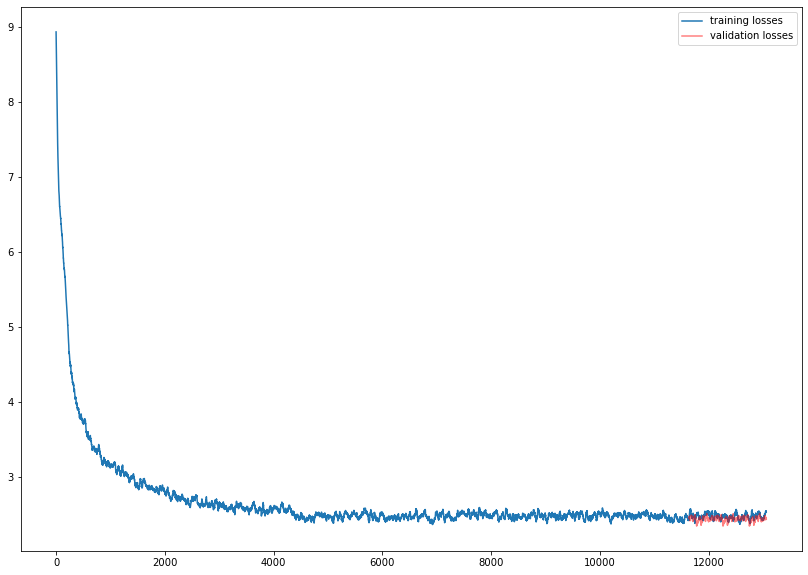

In [23]:
fix, ax = plt.subplots(figsize=(14, 10))
n_train_losses = len(train_mb_running_loss)
ax.plot(range(n_train_losses), train_mb_running_loss, label="training losses");
ax.plot(range(n_train_losses-len(val_mb_running_loss), n_train_losses),
        val_mb_running_loss, c="r", alpha=0.5, label="validation losses")
ax.legend();

## Evaluation

We will evaluate the trained model on a STS dataset. We will compare the finetuned model and the bert-base model. 

In [24]:
sts = hf_datasets.load_dataset("glue", "stsb", split="validation")
len(sts), sts[0]

Reusing dataset glue (/home/utsav/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


(1500,
 {'sentence1': 'A man with a hard hat is dancing.',
  'sentence2': 'A man wearing a hard hat is dancing.',
  'label': 5.0,
  'idx': 0})

In [25]:
sentence1s = [data["sentence1"] for data in sts]
sentence2s = [data["sentence2"] for data in sts]
normalized_labels = [data["label"] / 5 for data in sts]

In [26]:
def encode(
    input_texts: list[str], tokenizer: BertTokenizerFast, model: BertModel, device: str = "cpu"
) -> torch.tensor:

    model.eval()
    tokenized_texts = tokenizer(input_texts, max_length=MAX_LENGTH,
                                padding='max_length', truncation=True, return_tensors="pt")
    pooled_embeds = model(tokenized_texts["input_ids"].to(device),
                          tokenized_texts["attention_mask"].to(device)).pooler_output
    return pooled_embeds

In [36]:
def cos_sim_in_batches(
    batch_size: int, s1_texts: list[str], s2_texts: list[str],
    tokenizer: BertTokenizerFast, model: BertModel,
    cos_sim_f: Callable[[torch.tensor, torch.tensor], torch.tensor],
    device: str = "cuda"
) -> torch.tensor:

    cos_sims = None
    n_batches = len(s1_texts) // batch_size + int(len(s1_texts) % batch_size != 0)
    for i in range(n_batches):
        s1_batch = s1_texts[i*batch_size: (i+1)*batch_size]
        s2_batch = s2_texts[i*batch_size: (i+1)*batch_size]
        if i == 0:
            cos_sims = cos_sim_f(encode(s1_batch, tokenizer, model, device).detach(),
                                 encode(s2_batch, tokenizer, model, device).detach())
        else:
            _cos_sims = cos_sim_f(encode(s1_batch, tokenizer, model, device).detach(),
                                  encode(s2_batch, tokenizer, model, device).detach())
            cos_sims = torch.cat([cos_sims, _cos_sims])
    
    return cos_sims

In [28]:
cos_sim_f = torch.nn.CosineSimilarity()
sbert_cos_sims = cos_sim_in_batches(16, sentence1s, sentence2s, tokenizer, model.encoder, cos_sim_f)

In [29]:
stats.spearmanr(sbert_cos_sims.cpu().detach().numpy(), np.array(normalized_labels))

SpearmanrResult(correlation=0.6562854102049397, pvalue=1.742454940612208e-185)

In [58]:
bert_model = BertModel.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
bert_cos_sims = cos_sim_in_batches(16, sentence1s, sentence2s, tokenizer, bert_model, cos_sim_f, "cpu")
stats.spearmanr(bert_cos_sims.cpu().detach().numpy(), np.array(normalized_labels))

SpearmanrResult(correlation=0.15565973492337204, pvalue=1.3559203499038571e-09)

Our unsupervised finetuned model is doing much better on this semantic similarity dataset as compared to the bert-base model. It's not performing as good as the supervised training we did for Bi and Cross encoders(where we saw average spearman rank correlation of ~0.80) but that's to be expected.

** Note that we achieve .74 spearman rank correlation(vs 0.66 here) in the preivous notebook, using all the utils from sbert for training. Here we are using a differnt scheduler, but there might be other factors affecting our score which I'm not sure about.

Let's look how this model can be used for retrieval tasks.

In [106]:
def get_ranked_docs(
    model: BertModel, query: str, corpus_emebds: np.array, device: str="cuda"
) -> None:
    tokenized_query = tokenizer(query, max_length=MAX_LENGTH,
                                padding="max_length", truncation=True,
                                return_tensors="pt")
    query_embed = model(**tokenized_query.to(device)).pooler_output
    scores = util.cos_sim(query_embed, corpus_embeds)
    print(f"Query - {query}\n---")
    scores = scores.cpu().detach().numpy()[0]
    scores_ix = np.argsort(scores)[::-1]
    for ix in scores_ix:
        print(f"{scores[ix]: >.2f}\t{corpus[ix]}")

In [107]:
corpus = [
    "A man is eating food.",
    "A man is eating a piece of bread.",
    "The girl is carrying a baby.",
    "A man is riding a horse.",
    "A woman is playing violin.",
    "Two men pushed carts through the woods.",
    "A man is riding a white horse on an enclosed ground.",
    "A monkey is playing drums.",
    "A cheetah is running behind its prey."
]

query = "A man is eating pasta."

In [108]:
tokenized_corpus = tokenizer(corpus, max_length=MAX_LENGTH,
                             padding="max_length", truncation=True,
                             return_tensors="pt")

In [109]:
corpus_embeds = model.encoder(**tokenized_corpus.to("cuda")).pooler_output
get_ranked_docs(model.encoder, query, corpus_embeds, "cuda")

Query - A man is eating pasta.
---
0.81	A man is eating food.
0.76	A man is eating a piece of bread.
0.49	A man is riding a white horse on an enclosed ground.
0.48	A man is riding a horse.
0.43	A woman is playing violin.
0.33	A monkey is playing drums.
0.13	A cheetah is running behind its prey.
0.02	Two men pushed carts through the woods.
0.02	The girl is carrying a baby.


In [110]:
corpus_embeds = bert_model(**tokenized_corpus.to("cpu")).pooler_output
get_ranked_docs(bert_model, query, corpus_embeds, "cpu")

Query - A man is eating pasta.
---
1.00	A man is eating a piece of bread.
1.00	A woman is playing violin.
1.00	A man is riding a horse.
1.00	A monkey is playing drums.
0.99	A man is riding a white horse on an enclosed ground.
0.99	The girl is carrying a baby.
0.99	A man is eating food.
0.98	Two men pushed carts through the woods.
0.97	A cheetah is running behind its prey.


In [111]:
corpus = [
    "A man is eating food.",
    "A man is eating a piece of bread.",
    "A woman is playing violin.",
    "Two men pushed carts through the woods.",
    "A woman is practicing jumps with her horse.",
    "A horse is running around the track."
]

query = "Horse jumped over the obstacle."

In [112]:
tokenized_corpus = tokenizer(corpus, max_length=MAX_LENGTH,
                             padding="max_length", truncation=True,
                             return_tensors="pt")

In [113]:
corpus_embeds = model.encoder(**tokenized_corpus.to(device)).pooler_output
get_ranked_docs(model.encoder, query, corpus_embeds, "cuda")

Query - Horse jumped over the obstacle.
---
0.60	A horse is running around the track.
0.45	A woman is practicing jumps with her horse.
0.27	Two men pushed carts through the woods.
0.12	A man is eating food.
0.10	A man is eating a piece of bread.
-0.02	A woman is playing violin.


In [114]:
corpus_embeds = bert_model(**tokenized_corpus.to("cpu")).pooler_output
get_ranked_docs(bert_model, query, corpus_embeds, "cpu")

Query - Horse jumped over the obstacle.
---
0.98	Two men pushed carts through the woods.
0.98	A horse is running around the track.
0.98	A man is eating food.
0.97	A woman is playing violin.
0.96	A man is eating a piece of bread.
0.95	A woman is practicing jumps with her horse.


---

## References

[1] Kexin Wang, Nils Reimers and Iryna Gurevych. "[TSDAE: Using Transformer-based Sequential Denoising Auto-Encoder for Unsupervised Sentence Embedding Learning](https://arxiv.org/pdf/2104.06979.pdf)"

[2] https://github.com/UKPLab/sentence-transformers

[3] [BIER benchmark](https://arxiv.org/abs/2104.08663)